# Problema

## Introdução

O [Reuters](https://www.reuters.com/) é uma agência de notícias britânica mundialmente conhecida por conta do seu conteúdo diversificado e qualidade das postagens. Por possuir uma diversidade muito grande, o Reuters disponibilizou mundialmente um *dataset* contendo mais de 800 mil documentos manualmente categorizados para fins de pesquisa, para o insentivo no aprendizado de máquina e classificação de linguagem natural utilizando mecanismos de *Machine Learning*.

## Problemática

A problemática do [Reuters RCV1 RCV2 Multilingual, Multiview Text Categorization Test collection Data Set ](https://archive.ics.uci.edu/ml/datasets/Reuters+RCV1+RCV2+Multilingual,+Multiview+Text+Categorization+Test+collection) consiste em realizar a identificação da classe dos documentos dispostos do *Reuters Corpus, Volume 1* que são publicações em Inglês e do *Reuters Corpus, Volume 2* publicados em outras quatro linguas, sendo elas Francês, Alemão, Espanhol e Italiano, totalizando cinto linguas diferentes dos mesmos documentos. Dentro das diversas 134 classes conhecidas das postagens do *Reuters*, o *dataset* possui seis classes selecionadas. São elas: PERFORMANCE, CORPORATE/INDUSTRIAL, GOVERNMENT FINANCE, ECONOMICS, GOVERNMENT/SOCIAL, EQUITY MARKETS.

## Disponibilização dos dados

Os dados foram disponibilizados no formato parecido com o SVM *light*. Cada linha dos arquivos de dados consiste em um tipo de documento, disponibilizado da maneira:
```
class feature:value feature:value feature:value ... feature:value
```
* *Class*: é a categoria do documento, disposta no formato de string;
* *Feature*: é uma palavra disposta no texto;
* *Value*: é o peso dessa palavra dentro da identificação da classe.

Os dados de feature:value são ordenados de acordo com seu peso dentro de cada registro.

In [27]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Categorias do Documento  
Como explicado anteriormente, os textos são divididos em algumas categorias. Para processar os dados, deve-se converter essas strings em números.
É importante lembrar que antes de executar o programa deve-se descompactar o arquivo *rcv1rcv2aminigoutte.tar.gz* na pasta do projeto. Isso criará a pasta *rcv1rcv2aminigoutte*, que contém os arquivos necessários para o problema.

In [28]:
categories = {'C15': 4587, 'CCAT': 8745, 'E21': 9625, 'ECAT': 5656, 'GCAT': 5745, 'M11': 45845}

É necessário realizar um breve tratamento de dados para a permitir realizar a importação dos dados no formato SML Light. Para isso, criou-se o método abaixo que realiza a substituição das strings correspondentes às classes em seus respectivos números.

In [29]:
def filter_datas(file, target_file):
    with open(file, 'r') as document_read:
        with open(target_file, 'w') as document_write:
            for line in document_read:
                target = line.split(None, 1)[0]
                line_to_write = '%s %s' % (categories[target], line[len(target)+1:len(line)])
                document_write.write(line_to_write)
        
    return target_file

## Carregando o dataset no formato SVMLight

In [30]:
file = filter_datas('rcv1rcv2aminigoutte/EN/Index_EN-EN', 'svml_en_en.txt')
X,  y = load_svmlight_file(file)

## Aplicando a seleção das features

Dentro dos problemas que envolvem classificação, uma das partes mais importantes para obtenção de melhores resultados se dá na filtragem e identificação da relevância entre as demais características dos dados. Para isso, existem os métodos de *feature selection* que conseguem, a partir de cálculos matemáticos, identificar quais dessas características de fato são relevantes para a correta categorização ou classificação, aumentando assim a assertividade dos modelos. 

### Feature selection utilizado

Dentro dos diversos métodos de *feature selection*, foram testados os métodos utilizando o LinearSVC e o ExtraTreesClassifier, ambos em conjunto com o SelectFromModel, que é um modelo que remove as *features* identificadas como não importantes à partir de pesos de coeficientes ou *feature_importances*. Em todos os testes, o modelo utilizando o LinearSVC conseguiu reduzir consideravelmente mais *features* do que o ExtraTreesClassifier, e por isso foi o utilizado.

In [31]:
clf = ExtraTreesClassifier()
clf = clf.fit(X, y)
model = SelectFromModel(clf, prefit=True)
Trees_X_new = model.transform(X)

from sklearn.svm import LinearSVC

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
Linear_X_new = model.transform(X)

print('Data matrix shape before feature selection: ' + str(X.shape))
print('Data matrix shape after ExtraTreesClassifier feature selection: ' + str(Trees_X_new.shape))
print('Data matrix shape after LinearSVC feature selection: ' + str(Linear_X_new.shape))
X_new = Linear_X_new

Data matrix shape before feature selection: (18758, 21531)
Data matrix shape after ExtraTreesClassifier feature selection: (18758, 3034)
Data matrix shape after LinearSVC feature selection: (18758, 2683)


## Dividindo o dataset
O método *train_test_split* é bem útil para dividir os dados em partes que serão usados para o treino do modelo e os testes, que serão convenientes para avaliar o modelo. Os dados de treino estarão em *x_train* e *y_train*, e os dados de teste em *x_test* e *y_test*, sendo que 25% dos dados serão usados para os testes e os outros 75% para o treinamento.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X_new,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

## Métodos de Classificação

### Encontrando um bom k
Um dos parâmetros mais importantes no algoritmo do *KNeighborsClassifier* é o *k*, que significa quantos "vizinhos" mais próximos serão considerados para classificar um dado de teste. Por exemplo, se *k = 3*, serão analizadas as três classes vizinhas mais próximos, sendo que aquela que for mais comum irá classificar esse dado.

In [22]:
k_scores = []

for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    knn_score = knn.score(X_test, y_test)
    print('Score for k = ' + str(k) + ': ' + str(knn_score))
    
    k_scores.append(knn_score)

Score for k = 1: 0.6501066098081023
Score for k = 2: 0.588272921108742
Score for k = 3: 0.602771855010661
Score for k = 4: 0.5912579957356077
Score for k = 5: 0.5837953091684435
Score for k = 6: 0.5739872068230277
Score for k = 7: 0.5680170575692963
Score for k = 8: 0.5729211087420043
Score for k = 9: 0.5750533049040512
Score for k = 10: 0.5765458422174841


Para encontrar um bom *k*, foram feitos 10 testes, com *k* variando de 1 até 10. O modelo é testado a cada iteração e a acurácia é aferida. O maior resultado desses testes é um forte candidato para a escolha do *k*.

In [9]:
np_k_scores = np.asarray(k_scores)
best_k = np.argmax(np_k_scores) + 1
print('Best k to KNN Classifier: ' + str(best_k))

Best k to KNN Classifier: 1


### Avaliando o modelo
O modelo é criado utilizando o *k* que foi encontrado acima.  
Os dados de treino são usados para treinar o modelo através do método *fit*, enquanto os dados de teste são usados no método *predict* para testar o modelo.

In [10]:
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

#### Matriz de confusão
A matriz de confusão nos mostra os números de observações previstas em um grupo conhecido *i*, mas que foram previstos em um grupo *j*, ou seja, relaciona os valores reais com os previstos pelo classificador.

In [11]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [12]:
class_as_number = [4587, 8745, 9625, 5656, 5745, 45845]
confusion = confusion_matrix(y_test, y_pred, labels=class_as_number)

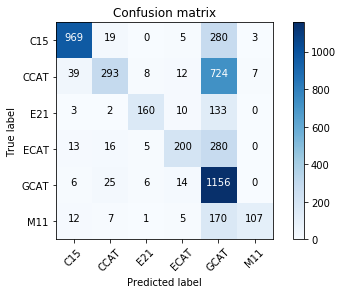

In [13]:
class_as_string = ['C15', 'CCAT', 'E21', 'ECAT', 'GCAT', 'M11']

plt.figure() 
plot_confusion_matrix(confusion, classes=class_as_string)

plt.show()

#### Relatório de classificação

In [14]:
report = classification_report(y_test, y_pred, labels=class_as_number, target_names=class_as_string)
print(report)

             precision    recall  f1-score   support

        C15       0.93      0.76      0.84      1276
       CCAT       0.81      0.27      0.41      1083
        E21       0.89      0.52      0.66       308
       ECAT       0.81      0.39      0.53       514
       GCAT       0.42      0.96      0.59      1207
        M11       0.91      0.35      0.51       302

avg / total       0.75      0.62      0.61      4690



### Modelo Random Forest

Um outro modelo de classificador é o chamado Random Forest. Ele é um método que consiste em criar uma floresta de árvores de decisões e alimentá-las com *sub-samples* do *dataset*, as quais concorrerão entre si e se ajustarão para obterem os maiores valores médios de acurácia e evitar o over-fitting. 

![Random forest](../images/random_forest.jpg)


In [38]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=500)
rfc.fit(X_train, y_train)

score = rfc.score(X_test, y_test)
prediction = rfc.predict(X_test)

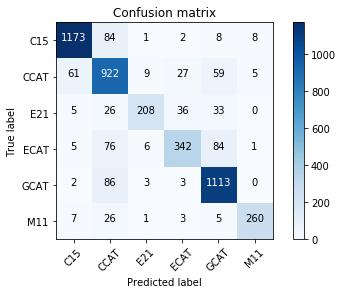

In [39]:
confusion = confusion_matrix(y_test, prediction, labels=class_as_number)
plt.figure() 
plot_confusion_matrix(confusion, classes=class_as_string)

plt.show()

In [37]:
report = classification_report(y_test, prediction, labels=class_as_number, target_names=class_as_string)
print(report)

             precision    recall  f1-score   support

        C15       0.93      0.92      0.93      1276
       CCAT       0.76      0.85      0.80      1083
        E21       0.91      0.69      0.79       308
       ECAT       0.84      0.68      0.75       514
       GCAT       0.86      0.92      0.89      1207
        M11       0.95      0.86      0.90       302

avg / total       0.86      0.86      0.86      4690

